In [1]:
import sys
sys.path.insert(0, '../code/')
from two_level import TwoLevel
import plot_two_level as plot
import numpy as np
import pandas as pd

#### Read in data

In [2]:
data = pd.read_csv('./data/diabetes_cleaned.csv')

In [3]:
#data.to_csv('./data/diabetes_cleaned.csv')

### Inputs

- `locations`: names of the child nodes.
- `integrand`: list of string, names of integrands
- `rates`: list of strings, names of rates
- `meas_noise_density`: dict of dict, mapping from measurement name to a dictionary specifying density corresponding to that measurement
- `rate_parent_priors`: list of tuples, where each tuple has 3 components:
    - prior on the rate, e.g. $\iota(a,t)$
    - prior on the rate change in age, e.g. $\iota(a_1,t) - \iota(a_2,t)$
    - prior on the rate change in time, e.g. $\iota(a,t_1) - \iota(a,t_2)$
    
    The length of `rate_priors` should be equal to the length of `rates`.
- `rate_child_priors`: list of tuples, where each tuple has 3 components:
    - prior on the rate random effects values, e.g. $u(a,t)$
    - prior on the change in random effects in age, e.g. $u(a_1,t) - u(a_2,t)$
    - prior on the change in random effects in time, e.g. $u(a,t_1) - u(a,t_2)$

- `path_to_db`: path to database
- `data`: a pandas dataframe, which must have the following columns:
    
    `age_start`,`age_end`,`year_start`,`year_end`, `mean`, `standard_error`, `location_name`
- `age_list` (optional): list of numbers, can pass an `age_list` to dismod_at. If empty the program will use all ages appeared in `age_start` and `age_end` from `data`
- `time_list` (optional) : similar to `age_list`

In [4]:
integrand = ['Sincidence']
locations = ['Denmark', 'Finland','Norway']
rates = ['iota']
#meas_noise_density = {'Sincidence':{'density':'students', 'nu': 30}}
meas_noise_density = {'Sincidence': {'density': 'gaussian'}}
rates_parent_priors = [
    # rate priors for iota
    ({'density':'uniform','upper':1.0,'lower':1e-10,'mean': .1},\
    {'density': 'gaussian', 'mean':0.0, 'std': .1},\
    {'density': 'gaussian', 'mean':0.0, 'std': .1})]
rates_child_priors = [
    # rate priors for iota
    ({'density':'gaussian','mean': 0.0, 'std': .1},\
    {'density': 'gaussian', 'mean':0.0, 'std': .1},\
    {'density': 'gaussian', 'mean':0.0, 'std': .1})]
#---------change path------------
path = './data/incidence_two_level.db'

In [5]:
time_list = np.append(np.arange(1965, 2015,5),[2016])
print(time_list)
model = TwoLevel(data, locations, integrand,rates, rates_parent_priors, 
                 rates_child_priors, meas_noise_density,path, time_list=time_list)

[1965 1970 1975 1980 1985 1990 1995 2000 2005 2010 2016]


In [6]:
data[(data['location_name'].isin(locations)) & (data['measure'] == 'Sincidence')].head()

,Unnamed: 0,age_start,age_end,year_start,year_end,mean,standard_error,measure,location_name
384,384,0,14.0,1994,1994,0.00040,0.0001,Sincidence,Finland
386,386,0,14.0,1998,1998,0.00050,0.0001,Sincidence,Finland
389,389,0,14.0,1999,1999,0.00045,0.0001,Sincidence,Finland
393,393,0,14.0,1991,1991,0.00040,0.0001,Sincidence,Finland
395,395,0,14.0,1990,1990,0.00035,0.0001,Sincidence,Finland


In [7]:
data.shape

(22493, 9)

### Fit model

#### fit one level (global level) only

In [8]:
import time
t0 = time.time()
model.fit_fixed(tol=1e-8)
print('elapsed time: ',time.time()-t0)

/home/prefix/dismod_at.release/bin/dismod_at ./data/incidence_two_level.db init
./data/incidence_two_level.db fit fixed
elapsed time:  2.290513038635254


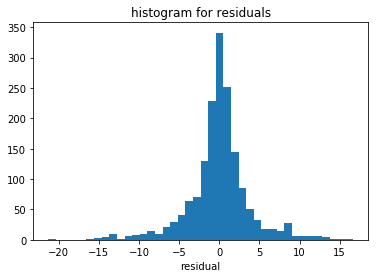

In [9]:
path = './data/'
plot.plot_residuals(path+'data.csv', 'world', bins=40);

#### fit two level (one parent + multiple children)

- no zero sum constraint

In [11]:
import time
t0 = time.time()
model.fit_both(fit_fixed=True, tol=1e-8, use_lambda=False)
print('elapsed time: ',time.time()-t0)

/home/prefix/dismod_at.release/bin/dismod_at ./data/incidence_two_level.db init
./data/incidence_two_level.db fit fixed
./data/incidence_two_level.db set start_var fit_var
./data/incidence_two_level.db fit both
elapsed time:  493.26401019096375


### Plots

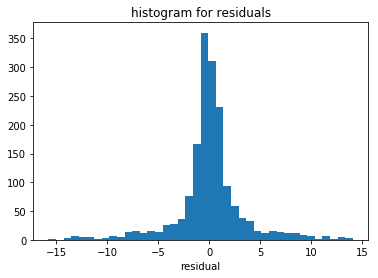

In [38]:
path = './data/'
plot.plot_residuals(path+'data.csv', 'world', bins=40);

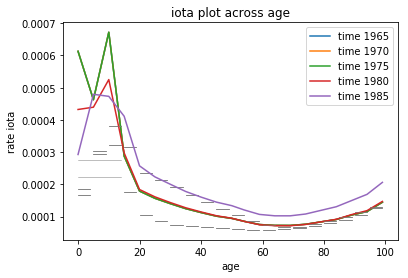

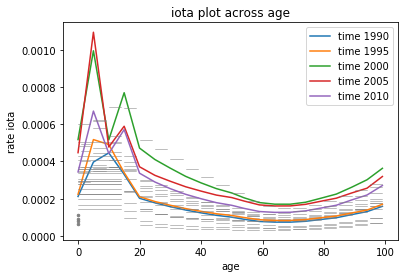

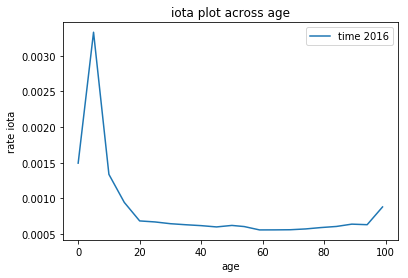

In [10]:
plot.plot_change_over_age('rate', 'iota', 'Sincidence', 'world',
                         path+'variable.csv',
                         path+'data.csv', time_list=model.time_list);

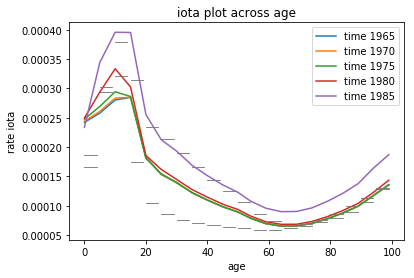

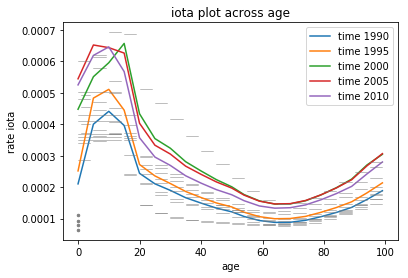

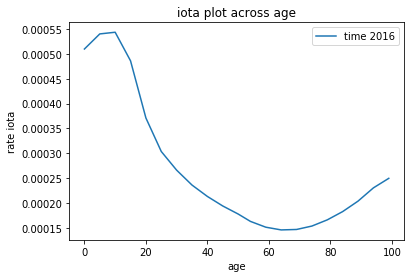

In [40]:
plot.plot_change_over_age('rate', 'iota', 'Sincidence', 'Finland',
                         path+'variable.csv',
                         path+'data.csv', time_list=model.time_list);

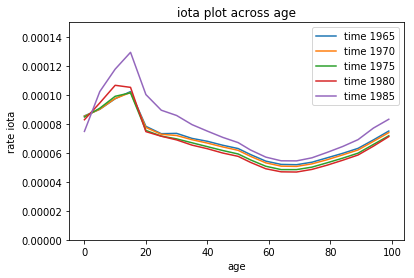

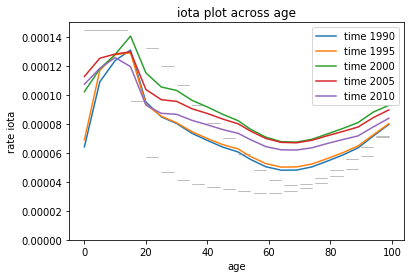

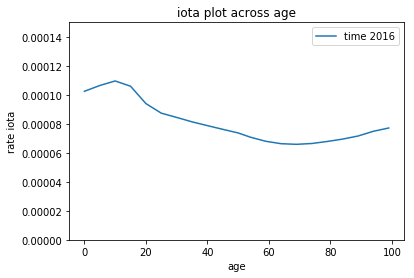

In [41]:
# --- sometime you need to fix the plotting range (specified ylim) so that all plots have the same plotting range
plot.plot_change_over_age('rate', 'iota', 'Sincidence', 'Denmark',
                         path+'variable.csv',
                         path+'data.csv', time_list=model.time_list, ylim=[0, .00015]);

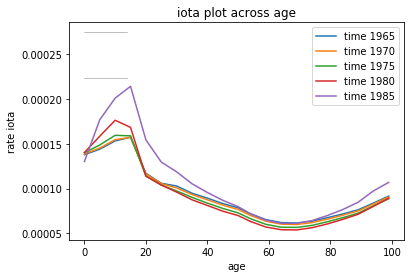

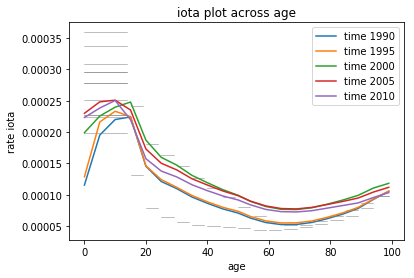

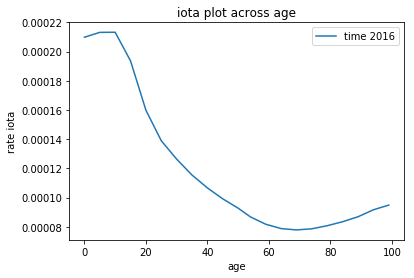

In [42]:
plot.plot_change_over_age('rate', 'iota', 'Sincidence', 'Norway',
                         path+'variable.csv',
                         path+'data.csv', time_list=model.time_list);

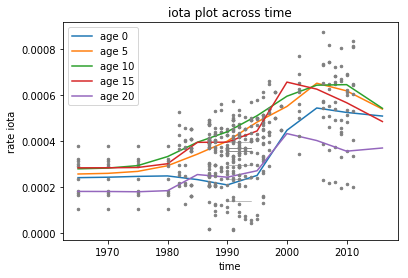

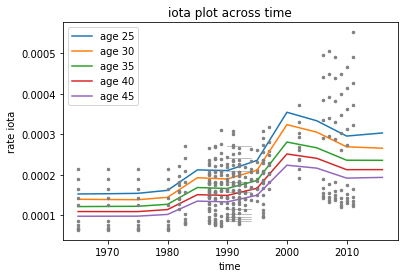

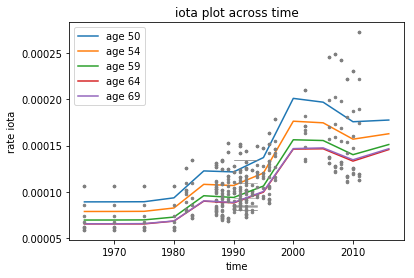

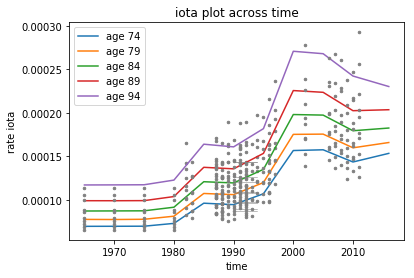

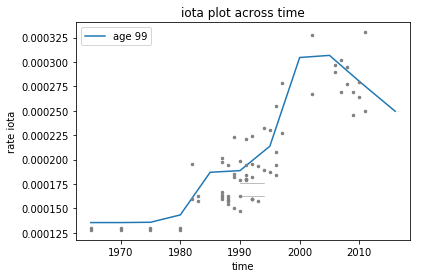

In [43]:
plot.plot_change_over_time('rate', 'iota', 'Sincidence', 'Finland', path+'variable.csv',
                       path+'data.csv', age_list=model.age_list, );

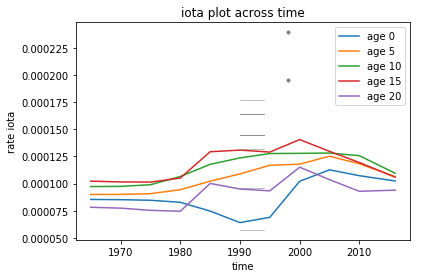

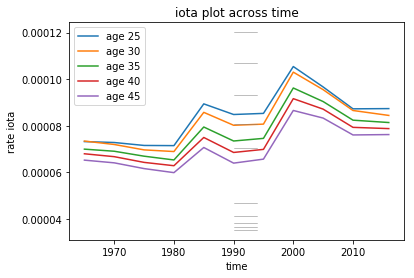

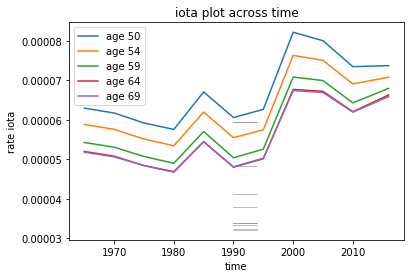

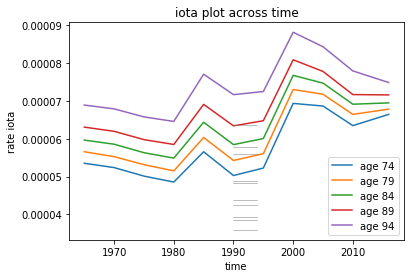

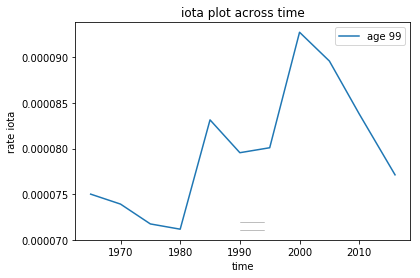

In [44]:
plot.plot_change_over_time('rate', 'iota', 'Sincidence', 'Denmark', path+'variable.csv',
                       path+'data.csv', age_list=model.age_list);

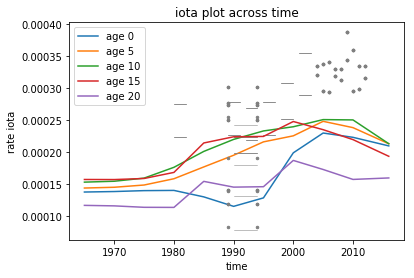

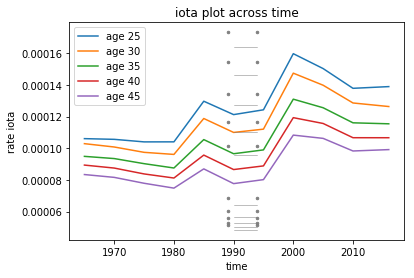

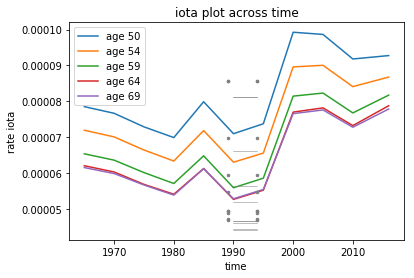

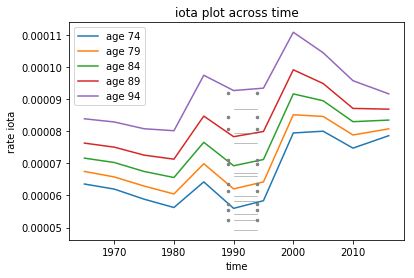

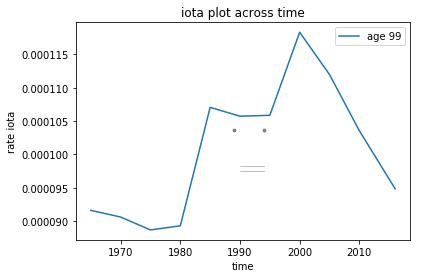

In [45]:
plot.plot_change_over_time('rate', 'iota', 'Sincidence', 'Norway', path+'variable.csv',
                       path+'data.csv', age_list=model.age_list);